# Iteration 1 - TableNet Model

> **Dataset**: Marmot Dataset <br/>
> **Model**: TableNet Model <br/>
> **Creator**: Ryo

## **Data Collection**

### Upload `kaggle.json`



To authenticate with Kaggle and access datasets or competitions, the `kaggle.json` file needs to be uploaded. This file contains your Kaggle API credentials, which allow interaction with Kaggle's services.

1. Ensure the `kaggle.json` file is ready on your local machine.
2. Run the code below to initiate the file upload process.
3. Select the `kaggle.json` file from your local directory when prompted.
4. Once uploaded, proceed with the next steps to set up the environment for Kaggle access.


In [1]:
# from google.colab import files

# files.upload()

### Download Marmot Dataset from Kaggle


This code snippet automates the setup process for accessing and downloading the Marmot dataset from Kaggle. It begins by creating a secure directory to store the kaggle.json file, which contains the necessary credentials for Kaggle API access. The kaggle.json file is then copied into this directory, and its permissions are adjusted to ensure only the current user can read it, enhancing security. After setting up the credentials, the script downloads the Marmot dataset directly from Kaggle, extracts its contents into a specified directory, and then removes the original zip file to free up space. This sequence ensures that the dataset is ready for use in the working environment.

In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d ritvik1909/marmot-dataset
# !mkdir -p /content/marmot_data
# !unzip marmot-dataset.zip -d /content/marmot_data
# !rm marmot-dataset.zip

### Install Additional Packages

- **pytesseract**: `pytesseract` is a Python wrapper for Google's Tesseract-OCR engine, used to extract text from images through Optical Character Recognition (OCR), commonly applied in tasks involving text recognition in scanned documents or photos.

- **albumentations**: `albumentations` is a fast and versatile image augmentation library designed to enhance training data for deep learning models by applying various transformations, such as rotations, flips, and color adjustments, to create more diverse training examples and improve model generalization.

In [3]:
# !sudo apt install tesseract-ocr

In [4]:
# import subprocess

In [5]:
# def install_package(package_name):
#     """
#     Installs a Python package using pip and suppresses all output.
#     Prints a success message if the installation is successful,
#     or a failure message if the installation fails.

#     :param package_name: The name of the package to be installed.
#     """
#     try:
#         # Attempt to install the package while suppressing output
#         subprocess.check_call(['pip', 'install', package_name], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#         # Print success message if installation is successful
#         print(f"Successfully installed {package_name}")
#     except subprocess.CalledProcessError:
#         # Print failure message if installation fails
#         print(f"Failed to install {package_name}")

# # Install the pytesseract package
# install_package('pytesseract')

# # Install the albumentations package with upgrade option
# install_package('albumentations')

## **Data Understanding**

### Import Libraries

In [6]:
import os
import random
import shutil
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.models import load_model
import pytesseract
import albumentations as A

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

d:\Software\Python\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Global Variables

In [7]:
# Specify the path to the base folder
base_folder = '../data/marmot_data'

# Specify the paths to the xml, image, table mask, and column mask folders
xml_folder = os.path.join(base_folder, 'xml')
image_folder = os.path.join(base_folder, 'image')
table_mask_folder = os.path.join(base_folder, 'table_mask')
column_mask_folder = os.path.join(base_folder, 'column_mask')

In [8]:
BUFFER_SIZE = 100  # Buffer size for shuffling the dataset; larger values result in better shuffling
BATCH_SIZE = 1     # Number of samples processed before updating the model; higher values can improve computational efficiency
EPOCHS = 20        # Number of times the entire dataset is passed through the model during training

### Organize Files

#### *Functions*

In [9]:
def organize_files(base_folder):
    """
    Organize files by creating 'xml' and 'image' folders in the base directory.
    Moves .xml files to the 'xml' folder and .jpeg files to the 'image' folder,
    while showing a progress bar.

    Parameters:
    base_folder (str): The path to the base folder containing the 'data' folder.

    Returns:
    None
    """

    # Define paths for the new 'xml' and 'image' folders within the base directory
    xml_folder = os.path.join(base_folder, 'xml')
    image_folder = os.path.join(base_folder, 'image')
    data_folder = os.path.join(base_folder, 'data')

    # Create the 'xml' and 'image' folders if they don't already exist
    os.makedirs(xml_folder, exist_ok=True)
    os.makedirs(image_folder, exist_ok=True)

    # Check if the 'data' folder exists in the base directory
    if os.path.exists(data_folder):
        # List all files inside the 'data' folder
        files = os.listdir(data_folder)

        # Initialize a progress bar to track the file organization process
        with tqdm(total=len(files), desc="Organizing files", unit="file", ncols=100) as pbar:
            for file_name in files:
                # Construct the full file path for the current file
                file_path = os.path.join(data_folder, file_name)

                try:
                    # Move .xml files to the 'xml' folder
                    if file_name.endswith('.xml'):
                        shutil.move(file_path, os.path.join(xml_folder, file_name))
                        # Update the progress bar with the current status
                        pbar.set_postfix({"Moved": f"{file_name} to xml"})
                    # Move .jpeg files to the 'image' folder
                    elif file_name.endswith('.jpeg'):
                        shutil.move(file_path, os.path.join(image_folder, file_name))
                        # Update the progress bar with the current status
                        pbar.set_postfix({"Moved": f"{file_name} to image"})
                except Exception as e:
                    # Log any errors that occur during the file moving process
                    pbar.write(f"Error processing {file_name}: {str(e)}")

                # Increment the progress bar for each processed file
                pbar.update(1)

        # Remove the 'data' folder after all files have been moved
        shutil.rmtree(data_folder)
        print(f"Deleted folder: {data_folder}")
    else:
        # Notify the user if the 'data' folder is not found in the base directory
        print(f"No 'data' folder found in {base_folder}")

#### *Implementation*

In [10]:
organize_files(base_folder)

No 'data' folder found in ../data/marmot_data


### Count File Types

#### *Function*

In [11]:
def count_file_types(xml_folder, image_folder):
    """
    Count the number of .jpeg files in the image folder and .xml files in the xml folder.

    Parameters:
    xml_folder (str): The path to the folder containing the .xml files.
    image_folder (str): The path to the folder containing the .jpeg files.

    Returns:
    tuple: A tuple containing the count of .jpeg and .xml files.
    """

    # Count the number of .xml files in the xml folder by filtering files that end with .xml
    xml_count = len([file for file in os.listdir(xml_folder) if file.endswith('.xml')])

    # Count the number of .jpeg files in the image folder by filtering files that end with .jpeg
    jpeg_count = len([file for file in os.listdir(image_folder) if file.endswith('.jpeg')])

    # Return the counts as a tuple (jpeg_count, xml_count)
    return jpeg_count, xml_count

#### *Implementation*

In [12]:
jpeg_count, xml_count = count_file_types(xml_folder, image_folder)

# Print the results
print(f"Total .jpeg files: {jpeg_count}")
print(f"Total .xml files: {xml_count}")

Total .jpeg files: 494
Total .xml files: 494


### Check File Pairs

#### *Function*

In [13]:
def check_file_pairs(xml_folder, image_folder):
    """
    Check for matching pairs of .jpeg files in the image folder and .xml files in the xml folder.

    Parameters:
    xml_folder (str): The path to the folder containing the .xml files.
    image_folder (str): The path to the folder containing the .jpeg files.

    Returns:
    dict: A dictionary containing lists of unmatched .jpeg and .xml files.
    """
    # Create a set of file names (without extensions) from the .jpeg files in the image folder
    jpeg_files = set(os.path.splitext(file)[0] for file in os.listdir(image_folder) if file.endswith('.jpeg'))

    # Create a set of file names (without extensions) from the .xml files in the xml folder
    xml_files = set(os.path.splitext(file)[0] for file in os.listdir(xml_folder) if file.endswith('.xml'))

    # Identify .jpeg files that do not have a corresponding .xml file
    unmatched_jpeg = jpeg_files - xml_files

    # Identify .xml files that do not have a corresponding .jpeg file
    unmatched_xml = xml_files - jpeg_files

    # Return a dictionary with lists of unmatched .jpeg and .xml files
    return {
        'unmatched_jpeg': list(unmatched_jpeg),
        'unmatched_xml': list(unmatched_xml)
    }

#### *Implementation*

In [14]:
# Call the check_file_pairs function to find unmatched .jpeg and .xml files
unmatched_files = check_file_pairs(xml_folder, image_folder)

# Check if there are any unmatched .jpeg or .xml files
if unmatched_files['unmatched_jpeg'] or unmatched_files['unmatched_xml']:
    # If there are unmatched files, print the lists of unmatched .jpeg and .xml files
    print("Unmatched .jpeg files:", unmatched_files['unmatched_jpeg'])
    print("Unmatched .xml files:", unmatched_files['unmatched_xml'])
else:
    # If all files are properly paired, print a confirmation message
    print("All .jpeg and .xml files are properly paired.")

All .jpeg and .xml files are properly paired.


### Display Image

#### *Function*

In [15]:
def display_random_images_separately(folder_path, num_images=5):
    """
    Display a specified number of random .jpeg images from a given folder using OpenCV.
    Each image will be displayed in a separate plot to allow for larger size.

    Parameters:
    folder_path (str): The path to the folder containing the images.
    num_images (int): The number of images to display (default is 5).

    Returns:
    None
    """
    # List all .jpeg files in the specified folder
    jpeg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpeg')]

    # Check if the requested number of images exceeds the available images
    if num_images > len(jpeg_files):
        print(f"Only {len(jpeg_files)} images are available.")
        num_images = len(jpeg_files)  # Adjust the number of images to the available amount

    # Randomly select the specified number of images from the list
    random_images = random.sample(jpeg_files, num_images)

    # Loop through the selected images and display each one separately
    for image_file in random_images:
        # Construct the full path to the image file
        img_path = os.path.join(folder_path, image_file)

        # Read the image using OpenCV
        img = cv2.imread(img_path)

        # Convert the image from BGR to RGB for correct color display in Matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Create a new figure for each image with a larger size
        plt.figure(figsize=(8, 8))

        # Display the image
        plt.imshow(img_rgb)

        # Hide the axes for a cleaner display
        plt.axis('off')

        # Show the image plot
        plt.show()

#### *Implementation*

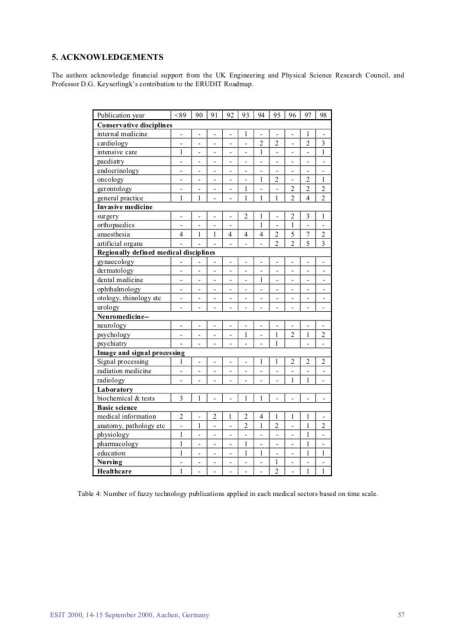

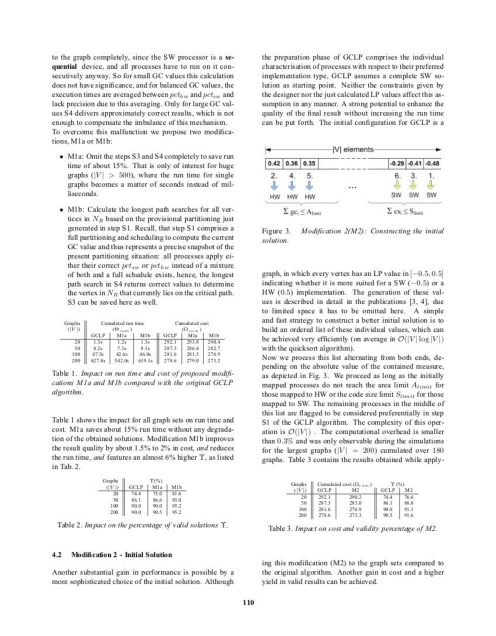

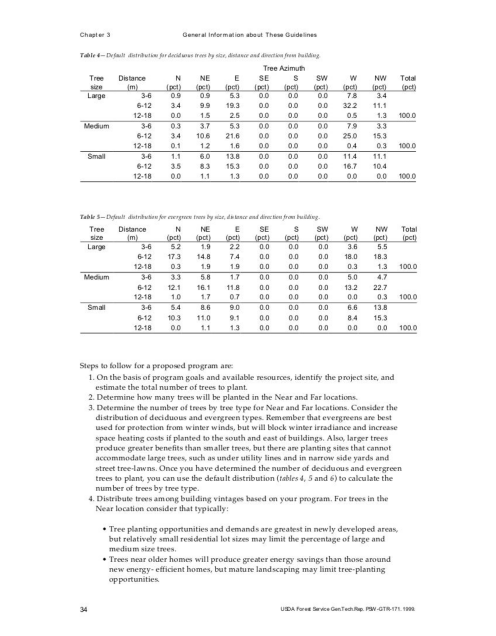

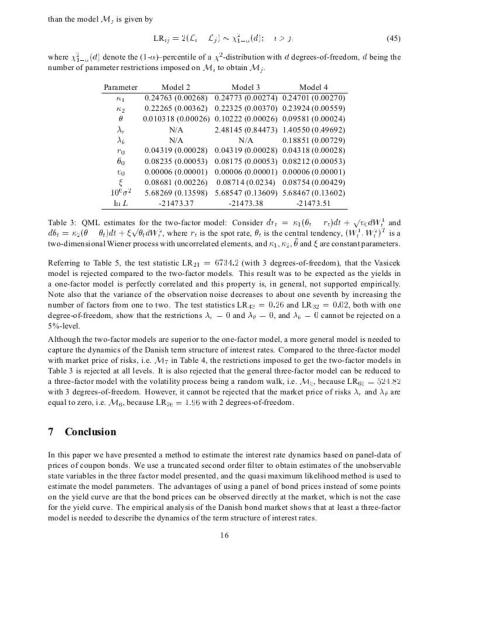

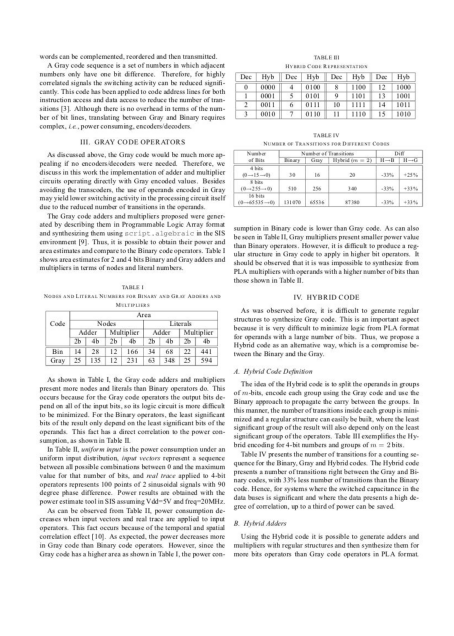

In [16]:
display_random_images_separately(image_folder)

### Display XML File

#### *Function*

In [17]:
def display_random_xml_content(folder_path):
    """
    Display the content of a random .xml file from the specified folder.

    Parameters:
    folder_path (str): The path to the folder containing the .xml files.

    Returns:
    None
    """
    # List all .xml files in the specified folder
    xml_files = [f for f in os.listdir(folder_path) if f.endswith('.xml')]

    # Check if there are any .xml files in the folder
    if not xml_files:
        # If no .xml files are found, notify the user and exit the function
        print("No .xml files found in the folder.")
        return

    # Randomly select one .xml file from the list
    random_xml_file = random.choice(xml_files)

    # Construct the full path to the selected .xml file
    xml_path = os.path.join(folder_path, random_xml_file)

    # Open the selected .xml file and read its content
    with open(xml_path, 'r') as file:
        xml_content = file.read()

        # Print the name of the file and its content
        print(f"Content of {random_xml_file}:\n")
        print(xml_content)

#### *Implementation*

In [18]:
display_random_xml_content(xml_folder)

Content of 10.1.1.1.2098_12.xml:

<annotation>
	<folder>MARMOT_ANNOTATION</folder>
	<filename>10.1.1.1.2098_12.bmp</filename>
	<path>/home/monika/Desktop/MARMOT_ANNOTATION/10.1.1.1.2098_12.bmp</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>816</width>
		<height>1056</height>
		<depth>1</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>column</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>288</xmin>
			<ymin>644</ymin>
			<xmax>351</xmax>
			<ymax>775</ymax>
		</bndbox>
	</object>
	<object>
		<name>column</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>357</xmin>
			<ymin>645</ymin>
			<xmax>394</xmax>
			<ymax>776</ymax>
		</bndbox>
	</object>
	<object>
		<name>column</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>401</xmin>
			<ymin>643</ymin>
			<xmax>437</xmax>
			

### Calculate Eucledian Distance

#### *Function*

In [19]:
def calculate_euclidean_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    The Euclidean distance is the straight-line distance between two points
    in a 2D space (like the distance between two points on a graph). It is
    calculated as the square root of the sum of the squared differences
    between corresponding coordinates of the points.

    Parameters:
    point1 (numpy array): Coordinates of the first point (x, y).
    point2 (numpy array): Coordinates of the second point (x, y).

    Returns:
    float: The Euclidean distance between the two points.
    """
    # Calculate the Euclidean distance using the norm function from numpy
    return np.linalg.norm(point1 - point2)

### Save Numpy Array as Image

#### *Function*

In [20]:
def save_image(image_array, path):
    """
    Save a numpy array as an image file.

    This function takes image data in the form of a numpy array and saves it as an image file
    at the specified path. The image is saved using OpenCV's `imwrite` function, which supports
    various image formats such as .png, .jpg, etc., depending on the file extension provided in the path.

    Parameters:
    image_array (numpy array): The image data in numpy array format, where the array represents pixel values.
    path (str): The complete file path, including the name and extension, where the image will be saved.

    Returns:
    None
    """
    # Save the image to the specified path using OpenCV's imwrite function
    cv2.imwrite(path, image_array)


### Generate Masks

#### *Function*

In [21]:
def generate_column_and_table_masks(xml_folder, table_mask_folder, column_mask_folder):
    """
    Generate mask images for columns and tables from XML annotations.
    Masks are saved in separate directories for columns and tables.

    Parameters:
    xml_folder (str): The folder containing the XML files with annotations.
    table_mask_folder (str): The folder where the generated table masks will be saved.
    column_mask_folder (str): The folder where the generated column masks will be saved.

    Returns:
    None
    """
    # Create directories for table and column masks if they don't exist
    os.makedirs(table_mask_folder, exist_ok=True)
    os.makedirs(column_mask_folder, exist_ok=True)

    # List all XML files in the specified XML folder
    xml_files = [file for file in os.listdir(xml_folder) if file.endswith(".xml")]

    # Loop through each XML file to generate masks
    for xpath in tqdm(xml_files, desc="Generating masks", unit="file", ncols=100):
        # Parse the XML file and get the root element
        tree = ET.parse(os.path.join(xml_folder, xpath))
        root = tree.getroot()

        # Retrieve the image dimensions from the XML metadata
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        # Extract the base filename without extension for naming the mask files
        fname = os.path.splitext(root.find('filename').text)[0]

        # Initialize empty masks for columns and tables
        col_mask = np.zeros((height, width), dtype=np.uint8)
        table_mask = np.zeros((height, width), dtype=np.uint8)

        # Variables to keep track of table boundaries and state
        newTable = True
        fwdFlag = False
        bwdFlag = False
        table_xmin, table_xmax, table_ymin, table_ymax = 0, 0, 0, 0
        prev_dist = 0

        # Get all annotated objects (columns) from the XML
        objects = root.findall('object')
        for index, obj in enumerate(objects):
            # Extract the bounding box coordinates for the column
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            xmax = int(bndbox.find('xmax').text)
            ymin = int(bndbox.find('ymin').text)
            ymax = int(bndbox.find('ymax').text)

            # Create the column mask by setting the corresponding region to white (255)
            col_mask[ymin:ymax, xmin:xmax] = 255

            if len(objects) <= 2:
                # If there are 2 or fewer columns, consider them as part of the same table
                xmins = [int(obj.find('bndbox/xmin').text) for obj in objects]
                xmaxes = [int(obj.find('bndbox/xmax').text) for obj in objects]
                ymins = [int(obj.find('bndbox/ymin').text) for obj in objects]
                ymaxes = [int(obj.find('bndbox/ymax').text) for obj in objects]

                table_xmin = min(xmins)
                table_xmax = max(xmaxes)
                table_ymin = min(ymins)
                table_ymax = max(ymaxes)
                table_mask[table_ymin:table_ymax, table_xmin:table_xmax] = 255
                continue

            if index == 0:
                # Initialize previous coordinates for the first column
                prev_xmin, prev_xmax, prev_ymin, prev_ymax = xmin, xmax, ymin, ymax
            else:
                # Determine if the table is expanding forward or backward
                if xmin > prev_xmin and newTable:
                    table_xmin, table_ymin = prev_xmin, prev_ymin
                    newTable, fwdFlag = False, True
                if xmin < prev_xmin and newTable:
                    table_xmax, table_ymax = prev_xmax, prev_ymax
                    newTable, bwdFlag = False, True

                if fwdFlag:
                    # Calculate distance between current and previous column for forward movement
                    dist = calculate_euclidean_distance(np.array([xmin, ymin]), np.array([prev_xmax, prev_ymin]))
                    if prev_dist == 0:
                        prev_dist = dist
                    else:
                        if dist // prev_dist > 3:
                            newTable = True
                            table_mask[table_ymin:prev_ymax, table_xmin:prev_xmax] = 255
                            prev_dist = 0
                        if index == len(objects) - 1:
                            newTable = True
                            table_mask[table_ymin:ymax, table_xmin:xmax] = 255
                            prev_dist = 0

                if bwdFlag:
                    # Calculate distance between current and previous column for backward movement
                    dist = calculate_euclidean_distance(np.array([xmax, ymin]), np.array([prev_xmin, prev_ymin]))
                    if prev_dist == 0:
                        prev_dist = dist
                    else:
                        if dist // prev_dist > 3 or index == len(objects) - 1:
                            newTable = True
                            table_mask[prev_ymin:table_ymax, xmin:table_xmax] = 255
                            prev_dist = 0

                # Update previous column coordinates and distance for the next iteration
                prev_xmin, prev_xmax, prev_ymin, prev_ymax = xmin, xmax, ymin, ymax
                prev_dist = dist

        # Save the generated masks for columns and tables
        col_path = os.path.join(column_mask_folder, f"{fname}.jpeg")
        table_path = os.path.join(table_mask_folder, f"{fname}.jpeg")

        save_image(col_mask, col_path)
        save_image(table_mask, table_path)


#### *Implementation*

In [22]:
generate_column_and_table_masks(xml_folder, table_mask_folder, column_mask_folder)

Generating masks: 100%|█████████████████████████████████████████| 494/494 [00:17<00:00, 28.37file/s]


### Display Random Image

#### *Function*

In [23]:
def display_random_image_triplets(image_folder, table_mask_folder, column_mask_folder, num_triplets=5):
    """
    Display a specified number of random image triplets, where each triplet consists of:
    1. The original image
    2. The table mask
    3. The column mask

    Parameters:
    image_folder (str): The folder containing the original images.
    table_mask_folder (str): The folder containing the table mask images.
    column_mask_folder (str): The folder containing the column mask images.
    num_triplets (int): The number of image triplets to display (default is 5).

    Returns:
    None
    """
    # List all .jpeg image files in the specified image folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpeg')]

    # Check if the requested number of triplets exceeds the available images
    if num_triplets > len(image_files):
        print(f"Only {len(image_files)} images are available.")
        num_triplets = len(image_files)  # Adjust to the number of available images

    # Randomly select the specified number of images
    random_images = random.sample(image_files, num_triplets)

    # Loop through the selected images to display each triplet (original, table mask, column mask)
    for image_file in random_images:
        # Construct the full paths to the original image and corresponding masks
        original_image_path = os.path.join(image_folder, image_file)
        table_mask_path = os.path.join(table_mask_folder, image_file)
        column_mask_path = os.path.join(column_mask_folder, image_file)

        # Load the images from the respective paths
        original_image = cv2.imread(original_image_path)
        table_mask = cv2.imread(table_mask_path, cv2.IMREAD_GRAYSCALE)
        column_mask = cv2.imread(column_mask_path, cv2.IMREAD_GRAYSCALE)

        # Convert the original image from BGR to RGB format for correct color display in Matplotlib
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Create a figure with 3 subplots to display the original image, table mask, and column mask
        plt.figure(figsize=(15, 5))

        # Display the original image in the first subplot
        plt.subplot(1, 3, 1)
        plt.imshow(original_image_rgb)
        plt.title('Original Image')
        plt.axis('off')  # Hide the axes for a cleaner display

        # Display the table mask in the second subplot
        plt.subplot(1, 3, 2)
        plt.imshow(table_mask, cmap='gray')
        plt.title('Table Mask')
        plt.axis('off')  # Hide the axes for a cleaner display

        # Display the column mask in the third subplot
        plt.subplot(1, 3, 3)
        plt.imshow(column_mask, cmap='gray')
        plt.title('Column Mask')
        plt.axis('off')  # Hide the axes for a cleaner display

        # Show the complete figure with the three images
        plt.show()

#### *Implementation*

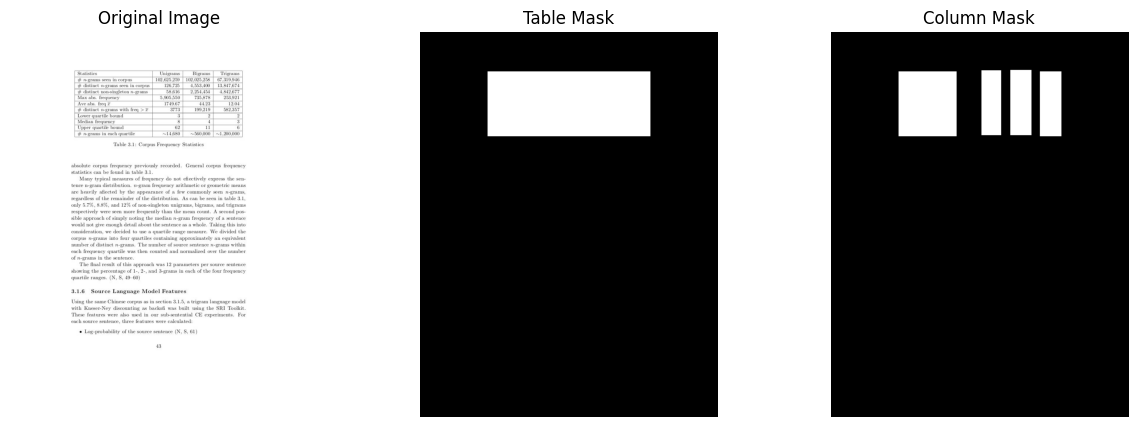

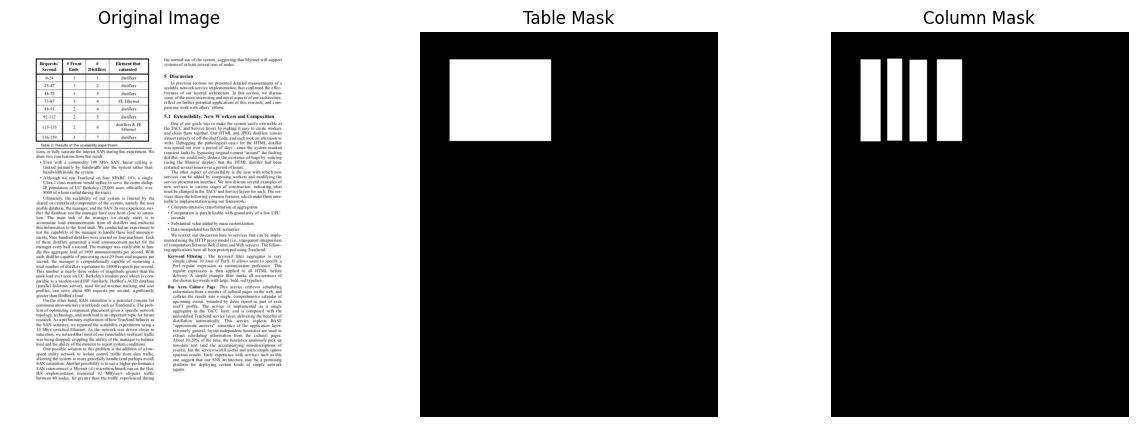

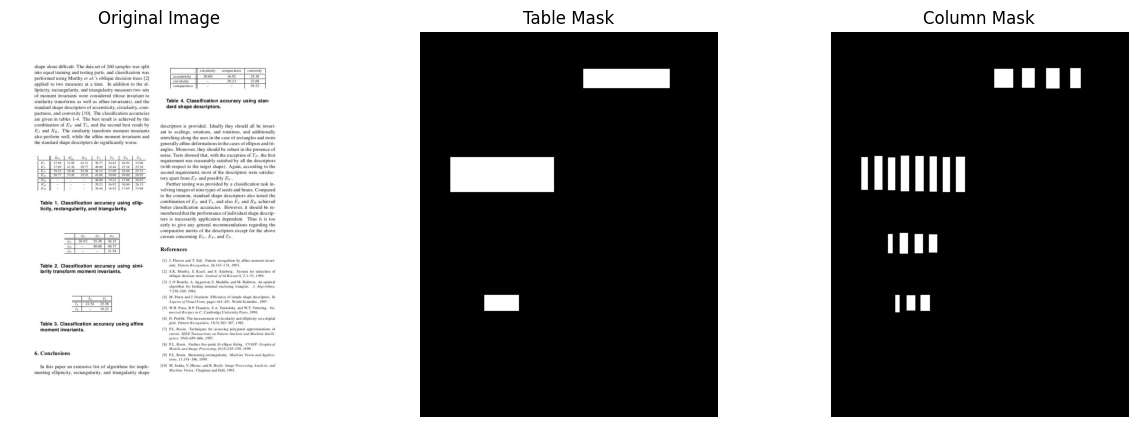

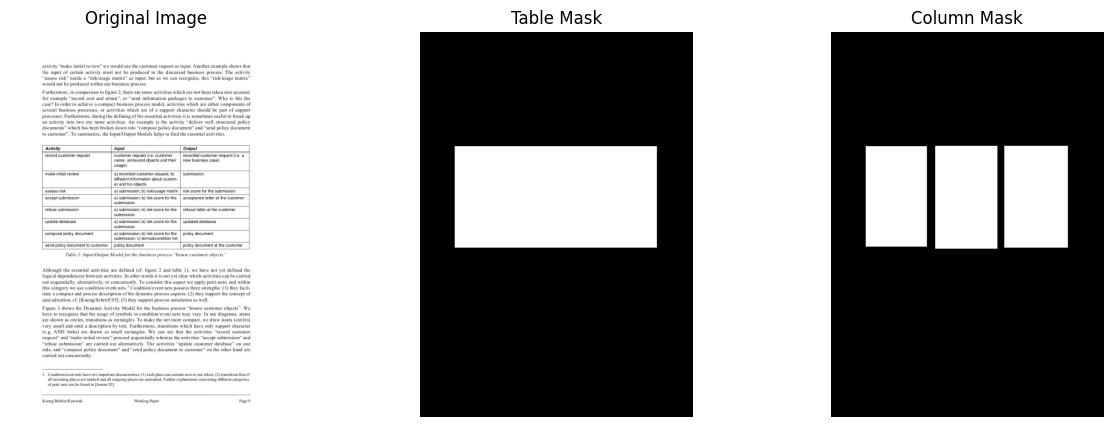

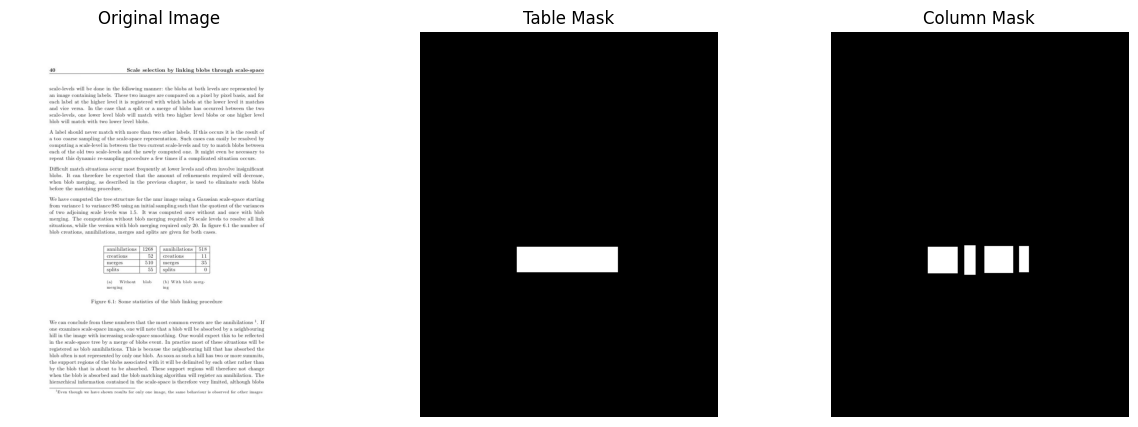

In [24]:
display_random_image_triplets(image_folder, table_mask_folder, column_mask_folder)

### Count Mask Files

#### *Function*

In [25]:
def count_mask_files(column_mask_folder, table_mask_folder):
    """
    Count the total number of files in the column mask and table mask folders.
    Also checks for any differences in the number of files between the two folders.

    Parameters:
    column_mask_folder (str): The path to the folder containing the column mask files.
    table_mask_folder (str): The path to the folder containing the table mask files.

    Returns:
    dict: A dictionary containing the counts and any discrepancies between the two folders.
    """
    # Count files in the column mask folder
    column_files = [f for f in os.listdir(column_mask_folder) if f.endswith('.jpeg')]
    column_count = len(column_files)

    # Count files in the table mask folder
    table_files = [f for f in os.listdir(table_mask_folder) if f.endswith('.jpeg')]
    table_count = len(table_files)

    # Find unmatched files
    unmatched_column = set(column_files) - set(table_files)
    unmatched_table = set(table_files) - set(column_files)

    # Return the counts and any discrepancies
    return {
        'column_count': column_count,
        'table_count': table_count,
        'unmatched_column': list(unmatched_column),
        'unmatched_table': list(unmatched_table)
    }

#### *Implementation*

In [26]:
# Get the counts and discrepancies
mask_file_info = count_mask_files(column_mask_folder, table_mask_folder)

# Print the results
print(f"Total .jpeg files in column_mask: {mask_file_info['column_count']}")
print(f"Total .jpeg files in table_mask: {mask_file_info['table_count']}")

if mask_file_info['unmatched_column'] or mask_file_info['unmatched_table']:
    print("Discrepancies found:")
    if mask_file_info['unmatched_column']:
        print(f"Files in column_mask but not in table_mask: {mask_file_info['unmatched_column']}")
    if mask_file_info['unmatched_table']:
        print(f"Files in table_mask but not in column_mask: {mask_file_info['unmatched_table']}")
else:
    print("No discrepancies found. All files are properly paired.")

Total .jpeg files in column_mask: 494
Total .jpeg files in table_mask: 494
No discrepancies found. All files are properly paired.


## **Data Preparation**

### Create File Pairs Dataframe

#### *Function*

In [27]:
def create_file_pairs_dataframe(image_folder, xml_folder, column_mask_folder, table_mask_folder):
    """
    Create a pandas DataFrame containing pairs of files from the specified folders.

    The DataFrame will include paths to the original images, XML annotation files,
    column masks, and table masks, providing a structured way to access related files.

    Parameters:
    image_folder (str): The path to the folder containing the original images.
    xml_folder (str): The path to the folder containing the XML annotation files.
    column_mask_folder (str): The path to the folder containing the column mask files.
    table_mask_folder (str): The path to the folder containing the table mask files.

    Returns:
    pd.DataFrame: A DataFrame with columns representing file paths in each folder.
    """
    # Get the file names without extensions from each specified folder
    image_files = set(os.path.splitext(f)[0] for f in os.listdir(image_folder) if f.endswith('.jpeg'))
    xml_files = set(os.path.splitext(f)[0] for f in os.listdir(xml_folder) if f.endswith('.xml'))
    column_mask_files = set(os.path.splitext(f)[0] for f in os.listdir(column_mask_folder) if f.endswith('.jpeg'))
    table_mask_files = set(os.path.splitext(f)[0] for f in os.listdir(table_mask_folder) if f.endswith('.jpeg'))

    # Create a sorted list of all unique file names across the four folders
    all_files = sorted(list(image_files | xml_files | column_mask_files | table_mask_files))

    # Initialize an empty DataFrame with columns for each file type
    df = pd.DataFrame(index=all_files, columns=['image', 'xml', 'column_mask', 'table_mask'])

    # Populate the DataFrame with full file paths, mapping file names to their corresponding paths
    df['image'] = df.index.map(lambda x: os.path.join(image_folder, x + '.jpeg') if x in image_files else None)
    df['xml'] = df.index.map(lambda x: os.path.join(xml_folder, x + '.xml') if x in xml_files else None)
    df['column_mask'] = df.index.map(lambda x: os.path.join(column_mask_folder, x + '.jpeg') if x in column_mask_files else None)
    df['table_mask'] = df.index.map(lambda x: os.path.join(table_mask_folder, x + '.jpeg') if x in table_mask_files else None)

    # Reset the index of the DataFrame to start from 0 and drop the original index
    df.reset_index(drop=True, inplace=True)

    return df

#### *Implementation*

In [28]:
# Create a DataFrame that pairs files from the image, XML, column mask, and table mask folders
file_pairs_df = create_file_pairs_dataframe(image_folder, xml_folder, column_mask_folder, table_mask_folder)

# Display the resulting DataFrame
file_pairs_df

,image,xml,column_mask,table_mask
0,../data/marmot_data\image\10.1.1.1.2006_3.jpeg,../data/marmot_data\xml\10.1.1.1.2006_3.xml,../data/marmot_data\column_mask\10.1.1.1.2006_...,../data/marmot_data\table_mask\10.1.1.1.2006_3...
1,../data/marmot_data\image\10.1.1.1.2013_63.jpeg,../data/marmot_data\xml\10.1.1.1.2013_63.xml,../data/marmot_data\column_mask\10.1.1.1.2013_...,../data/marmot_data\table_mask\10.1.1.1.2013_6...
2,../data/marmot_data\image\10.1.1.1.2013_64.jpeg,../data/marmot_data\xml\10.1.1.1.2013_64.xml,../data/marmot_data\column_mask\10.1.1.1.2013_...,../data/marmot_data\table_mask\10.1.1.1.2013_6...
3,../data/marmot_data\image\10.1.1.1.2014_4.jpeg,../data/marmot_data\xml\10.1.1.1.2014_4.xml,../data/marmot_data\column_mask\10.1.1.1.2014_...,../data/marmot_data\table_mask\10.1.1.1.2014_4...
4,../data/marmot_data\image\10.1.1.1.2014_6.jpeg,../data/marmot_data\xml\10.1.1.1.2014_6.xml,../data/marmot_data\column_mask\10.1.1.1.2014_...,../data/marmot_data\table_mask\10.1.1.1.2014_6...
...,...,...,...,...
489,../data/marmot_data\image\10.1.1.8.2182_6.jpeg,../data/marmot_data\xml\10.1.1.8.2182_6.xml,../data/marmot_data\column_mask\10.1.1.8.2182_...,../data/marmot_data\table_mask\10.1.1.8.2182_6...
490,../data/marmot_data\image\10.1.1.8.2185_13.jpeg,../data/marmot_data\xml\10.1.1.8.2185_13.xml,../data/marmot_data\column_mask\10.1.1.8.2185_...,../data/marmot_data\table_mask\10.1.1.8.2185_1...
491,../data/marmot_data\image\10.1.1.8.2185_14.jpeg,../data/marmot_data\xml\10.1.1.8.2185_14.xml,../data/marmot_data\column_mask\10.1.1.8.2185_...,../data/marmot_data\table_mask\10.1.1.8.2185_1...
492,../data/marmot_data\image\10.1.1.8.2198_11.jpeg,../data/marmot_data\xml\10.1.1.8.2198_11.xml,../data/marmot_data\column_mask\10.1.1.8.2198_...,../data/marmot_data\table_mask\10.1.1.8.2198_1...


### Split Train, Validation, and Test Data

#### *Function*

In [29]:
def split_dataset(df, test_size=0.2, val_size=0.1, random_state=42):
    """
    Split the DataFrame into train, validation, and test sets.

    Parameters:
    df (pd.DataFrame): The DataFrame to be split.
    test_size (float): The proportion of the dataset to include in the test set (default is 0.2).
    val_size (float): The proportion of the dataset to include in the validation set relative to the train set (default is 0.1).
    random_state (int): The random seed for reproducibility (default is 42).

    Returns:
    tuple: A tuple containing the train, validation, and test set DataFrames.
    """
    # Split the DataFrame into a combined train + validation set and a test set
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    # Further split the combined train + validation set into separate train and validation sets
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, random_state=random_state)

    return train_df, val_df, test_df

#### *Implementation*

In [30]:
# Split the data into train, validation, and test sets
train_df, val_df, test_df = split_dataset(file_pairs_df)

# Display the results
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 355
Validation set size: 40
Test set size: 99


In [31]:
print("Train set sample:")
train_df.head()

Train set sample:


,image,xml,column_mask,table_mask
181,../data/marmot_data\image\10.1.1.160.614_2.jpeg,../data/marmot_data\xml\10.1.1.160.614_2.xml,../data/marmot_data\column_mask\10.1.1.160.614...,../data/marmot_data\table_mask\10.1.1.160.614_...
468,../data/marmot_data\image\10.1.1.8.2117_32.jpeg,../data/marmot_data\xml\10.1.1.8.2117_32.xml,../data/marmot_data\column_mask\10.1.1.8.2117_...,../data/marmot_data\table_mask\10.1.1.8.2117_3...
52,../data/marmot_data\image\10.1.1.1.2087_15.jpeg,../data/marmot_data\xml\10.1.1.1.2087_15.xml,../data/marmot_data\column_mask\10.1.1.1.2087_...,../data/marmot_data\table_mask\10.1.1.1.2087_1...
38,../data/marmot_data\image\10.1.1.1.2063_4.jpeg,../data/marmot_data\xml\10.1.1.1.2063_4.xml,../data/marmot_data\column_mask\10.1.1.1.2063_...,../data/marmot_data\table_mask\10.1.1.1.2063_4...
284,../data/marmot_data\image\10.1.1.190.2741_19.jpeg,../data/marmot_data\xml\10.1.1.190.2741_19.xml,../data/marmot_data\column_mask\10.1.1.190.274...,../data/marmot_data\table_mask\10.1.1.190.2741...


In [32]:
print("Validation set sample:")
val_df.head()

Validation set sample:


,image,xml,column_mask,table_mask
209,../data/marmot_data\image\10.1.1.160.674_19.jpeg,../data/marmot_data\xml\10.1.1.160.674_19.xml,../data/marmot_data\column_mask\10.1.1.160.674...,../data/marmot_data\table_mask\10.1.1.160.674_...
343,../data/marmot_data\image\10.1.1.35.9666_3.jpeg,../data/marmot_data\xml\10.1.1.35.9666_3.xml,../data/marmot_data\column_mask\10.1.1.35.9666...,../data/marmot_data\table_mask\10.1.1.35.9666_...
4,../data/marmot_data\image\10.1.1.1.2014_6.jpeg,../data/marmot_data\xml\10.1.1.1.2014_6.xml,../data/marmot_data\column_mask\10.1.1.1.2014_...,../data/marmot_data\table_mask\10.1.1.1.2014_6...
340,../data/marmot_data\image\10.1.1.34.7043_189.jpeg,../data/marmot_data\xml\10.1.1.34.7043_189.xml,../data/marmot_data\column_mask\10.1.1.34.7043...,../data/marmot_data\table_mask\10.1.1.34.7043_...
106,../data/marmot_data\image\10.1.1.12.797_2.jpeg,../data/marmot_data\xml\10.1.1.12.797_2.xml,../data/marmot_data\column_mask\10.1.1.12.797_...,../data/marmot_data\table_mask\10.1.1.12.797_2...


In [33]:
print("Test set sample:")
test_df.head()

Test set sample:


,image,xml,column_mask,table_mask
455,../data/marmot_data\image\10.1.1.7.2164_21.jpeg,../data/marmot_data\xml\10.1.1.7.2164_21.xml,../data/marmot_data\column_mask\10.1.1.7.2164_...,../data/marmot_data\table_mask\10.1.1.7.2164_2...
73,../data/marmot_data\image\10.1.1.1.2139_44.jpeg,../data/marmot_data\xml\10.1.1.1.2139_44.xml,../data/marmot_data\column_mask\10.1.1.1.2139_...,../data/marmot_data\table_mask\10.1.1.1.2139_4...
310,../data/marmot_data\image\10.1.1.20.2130_26.jpeg,../data/marmot_data\xml\10.1.1.20.2130_26.xml,../data/marmot_data\column_mask\10.1.1.20.2130...,../data/marmot_data\table_mask\10.1.1.20.2130_...
175,../data/marmot_data\image\10.1.1.160.604_22.jpeg,../data/marmot_data\xml\10.1.1.160.604_22.xml,../data/marmot_data\column_mask\10.1.1.160.604...,../data/marmot_data\table_mask\10.1.1.160.604_...
332,../data/marmot_data\image\10.1.1.33.8442_10.jpeg,../data/marmot_data\xml\10.1.1.33.8442_10.xml,../data/marmot_data\column_mask\10.1.1.33.8442...,../data/marmot_data\table_mask\10.1.1.33.8442_...


### Extract Paths

#### *Function*

In [34]:
def extract_paths(df):
    """
    Extract paths for images, column masks, and table masks from the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the file paths.

    Returns:
    tuple: A tuple containing three numpy arrays for image_paths, column_mask_paths, and table_mask_paths.
    """
    # Extract the paths for images, column masks, and table masks from the DataFrame
    image_paths = df['image'].values
    column_mask_paths = df['column_mask'].values
    table_mask_paths = df['table_mask'].values

    return image_paths, column_mask_paths, table_mask_paths

#### *Implementation*

In [35]:
# Extract paths for training data
train_image_paths, train_column_mask_paths, train_table_mask_paths = extract_paths(train_df)

# Extract paths for validation data
val_image_paths, val_column_mask_paths, val_table_mask_paths = extract_paths(val_df)

# Extract paths for testing data
test_image_paths, test_column_mask_paths, test_table_mask_paths = extract_paths(test_df)

### Augmentation Training Data

#### *Function*

In [36]:
# Define the augmentations for the training dataset
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),          # Randomly flip the image horizontally with a 50% chance
    A.VerticalFlip(p=0.5),            # Randomly flip the image vertically with a 50% chance
    A.RandomRotate90(p=0.5),          # Randomly rotate the image by 90 degrees with a 50% chance
    A.RandomBrightnessContrast(p=0.2) # Randomly adjust brightness and contrast with a 20% chance
])

### Preprocess & Augmentation

#### *Function*

In [37]:
def preprocess_and_augment(image_path, column_mask_path, table_mask_path, augment=True):
    """
    Preprocess and optionally augment the images and masks.

    Parameters:
    image_path (str): The path to the image file.
    column_mask_path (str): The path to the column mask file.
    table_mask_path (str): The path to the table mask file.
    augment (bool): Whether to apply augmentations or not (default is True).

    Returns:
    tuple: The processed and optionally augmented image, column mask, and table mask.
    """
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Read and decode the column mask
    column_mask = tf.io.read_file(column_mask_path)
    column_mask = tf.image.decode_jpeg(column_mask, channels=1)

    # Read and decode the table mask
    table_mask = tf.io.read_file(table_mask_path)
    table_mask = tf.image.decode_jpeg(table_mask, channels=1)

    # Convert tensors to numpy arrays for augmentation
    image = image.numpy()
    column_mask = column_mask.numpy()
    table_mask = table_mask.numpy()

    # Apply augmentations if requested
    if augment:
        augmented = augmentations(image=image, masks=[column_mask, table_mask])
        image = augmented['image']
        column_mask, table_mask = augmented['masks']

    # Resize images and masks to a standard size
    image = tf.image.resize(image, [1024, 1024])
    column_mask = tf.image.resize(column_mask, [1024, 1024])
    table_mask = tf.image.resize(table_mask, [1024, 1024])

    # Normalize images and masks to the range [0, 1]
    image = image / 255.0
    column_mask = column_mask / 255.0
    table_mask = table_mask / 255.0

    return image, column_mask, table_mask

### Parse Image

#### *Function*

In [38]:
def parse_image(image_path, column_mask_path, table_mask_path, augment=True):
    """
    Function to call preprocess_and_augment using tf.py_function and
    explicitly set the shape of the tensors.

    Parameters:
    image_path (tf.Tensor): Path to the image.
    column_mask_path (tf.Tensor): Path to the column mask.
    table_mask_path (tf.Tensor): Path to the table mask.
    augment (bool): Whether to apply augmentations or not (default is True).

    Returns:
    tuple: Augmented and processed image, column mask, and table mask tensors.
    """
    # Call preprocess_and_augment using tf.py_function to allow non-TensorFlow operations
    [image, column_mask, table_mask] = tf.py_function(
        preprocess_and_augment,
        [image_path, column_mask_path, table_mask_path, augment],
        [tf.float32, tf.float32, tf.float32]
    )

    # Explicitly set the shape for the output tensors
    image.set_shape([1024, 1024, 3])
    column_mask.set_shape([1024, 1024, 1])
    table_mask.set_shape([1024, 1024, 1])

    return image, (column_mask, table_mask)

### Load TF Dataset

#### *Function*

In [39]:
def load_dataset(image_paths, column_mask_paths, table_mask_paths, batch_size, augment=True):
    """
    Create a tf.data.Dataset from the provided paths.

    This function constructs a TensorFlow Dataset object from image, column mask, and table mask paths.
    The dataset is then processed with optional augmentation, batched, and prefetched for efficiency.

    Parameters:
    image_paths (np.array): Array of paths to the images.
    column_mask_paths (np.array): Array of paths to the column masks.
    table_mask_paths (np.array): Array of paths to the table masks.
    batch_size (int): The size of each batch.
    augment (bool): Whether to apply augmentations or not (default is True).

    Returns:
    tf.data.Dataset: A batched and preprocessed TensorFlow Dataset.
    """
    # Create a Dataset object from the image, column mask, and table mask paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, column_mask_paths, table_mask_paths))

    # Map the parsing and augmentation function to the dataset elements
    dataset = dataset.map(lambda img, col_mask, tbl_mask: parse_image(img, col_mask, tbl_mask, augment),
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the dataset
    dataset = dataset.batch(batch_size)

    # Prefetch the dataset to improve performance by overlapping the preprocessing and model execution
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset, len(image_paths)


#### *Implementation*

In [40]:
# Create the training dataset with augmentation enabled
train_dataset, train_size = load_dataset(
    train_image_paths,
    train_column_mask_paths,
    train_table_mask_paths,
    BATCH_SIZE,
    augment=True
)

# Create the validation dataset without augmentation
val_dataset, val_size = load_dataset(
    val_image_paths,
    val_column_mask_paths,
    val_table_mask_paths,
    BATCH_SIZE,
    augment=False
)

# Create the test dataset without augmentation
test_dataset = load_dataset(
    test_image_paths,
    test_column_mask_paths,
    test_table_mask_paths,
    BATCH_SIZE,
    augment=False
)


In [54]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024, 1024, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1024, 1024, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1024, 1024, 1), dtype=tf.float32, name=None)))>

### Visualize Batch

#### *Function*

In [42]:
def visualize_batch(batch, num_samples=5):
    """
    Visualize a batch of processed images and masks.

    This function displays a specified number of samples from a batch, including
    the original image, the column mask, and the table mask, in a side-by-side layout.

    Parameters:
    batch (tuple): A tuple containing images and a tuple of masks (column_masks, table_masks).
    num_samples (int): The number of samples to visualize (default is 5).
    """
    # Unpack the batch into images, column masks, and table masks
    images, (column_masks, table_masks) = batch

    # Convert tensors to numpy arrays for visualization
    images = images.numpy()
    column_masks = column_masks.numpy()
    table_masks = table_masks.numpy()

    # Determine the actual number of samples to visualize
    batch_size = images.shape[0]
    num_samples = min(num_samples, batch_size)

    # Print information about the batch size and the shapes of the images and masks
    print(f"Batch size: {batch_size}")
    print(f"Image shape: {images.shape}")
    print(f"Column mask shape: {column_masks.shape}")
    print(f"Table mask shape: {table_masks.shape}")

    # Loop through the specified number of samples to visualize them
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))

        # Visualize the original image
        plt.subplot(131)
        plt.imshow(images[i])
        plt.title(f"Sample {i+1}: Image")
        plt.axis('off')  # Hide the axes for a cleaner display

        # Visualize the column mask
        plt.subplot(132)
        plt.imshow(column_masks[i, :, :, 0], cmap='gray')
        plt.title(f"Sample {i+1}: Column Mask")
        plt.axis('off')  # Hide the axes for a cleaner display

        # Visualize the table mask
        plt.subplot(133)
        plt.imshow(table_masks[i, :, :, 0], cmap='gray')
        plt.title(f"Sample {i+1}: Table Mask")
        plt.axis('off')  # Hide the axes for a cleaner display

        # Display the figure
        plt.show()

#### *Implementation*

Batch size: 1
Image shape: (1, 1024, 1024, 3)
Column mask shape: (1, 1024, 1024, 1)
Table mask shape: (1, 1024, 1024, 1)


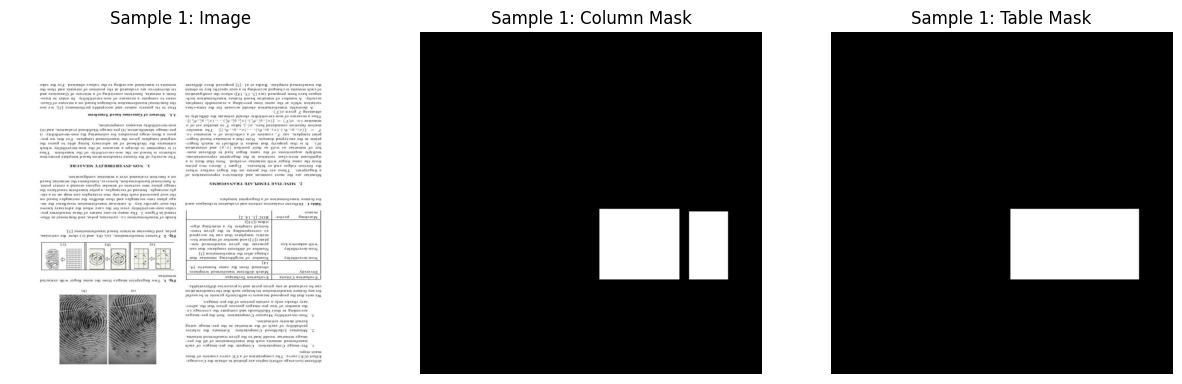

In [43]:
for batch in train_dataset.take(1):
    visualize_batch(batch)

## **Modeling**

### TableNet Architecture

In [44]:
def TableNet(input_shape=(1024, 1024, 3)):
    inputs = layers.Input(shape=input_shape)

    # VGG19 as encoder
    vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_tensor=inputs)

    # Freeze the encoder layers
    for layer in vgg19.layers:
        layer.trainable = False

    # Extract features from different layers of VGG19
    skip1 = vgg19.get_layer("block1_conv2").output
    skip2 = vgg19.get_layer("block2_conv2").output
    skip3 = vgg19.get_layer("block3_conv4").output
    skip4 = vgg19.get_layer("block4_conv4").output
    bottleneck = vgg19.get_layer("block5_conv4").output

    def decoder_block(x, skip_features, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip_features])
        x = layers.SeparableConv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.SeparableConv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.Dropout(0.2)(x)
        return x

    # Table output decoder
    x_table = decoder_block(bottleneck, skip4, 256)
    x_table = decoder_block(x_table, skip3, 128)
    x_table = decoder_block(x_table, skip2, 64)
    x_table = decoder_block(x_table, skip1, 32)
    table_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='table_output')(x_table)

    # Column output decoder
    x_column = decoder_block(bottleneck, skip4, 256)
    x_column = decoder_block(x_column, skip3, 128)
    x_column = decoder_block(x_column, skip2, 64)
    x_column = decoder_block(x_column, skip1, 32)
    column_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='column_output')(x_column)

    # Define the model
    model = models.Model(inputs=inputs, outputs=[table_output, column_output])

    return model

### Initialize TableNet Model

In [45]:
# Create the TableNet model with the specified input shape
model = TableNet(input_shape=(1024, 1024, 3))

# Display the model summary to review the architecture
model.summary()

d:\Software\Python\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 1024,      │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 1024,      │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 512, 512,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 512, 512,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 512, 512,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 256, 256,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 256, 256,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 256, 256,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 256, 256,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 256, 256,  │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 128, 128,  │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 128, 128,  │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 128, 128,  │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 128, 128,  │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 128, 128,  │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 64, 64,    │          0 │ block4_conv4[0][

 Total params: 22,158,530 (84.53 MB)

 Trainable params: 2,130,306 (8.13 MB)

 Non-trainable params: 20,028,224 (76.40 MB)

### Compile Model

In [46]:
# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metrics for both outputs
model.compile(
    optimizer='adam',
    loss={
        'table_output': 'binary_crossentropy',
        'column_output': 'binary_crossentropy'
    },
    loss_weights={
        'table_output': 1.0,
        'column_output': 1.0
    },
    metrics={
        'table_output': 'accuracy',
        'column_output': 'accuracy'
    }
)

### Train Model

In [47]:
# # Training
# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=10,
#     verbose=1
# )

## **Evaluation**

### Evaluate Model

#### *Function*

In [48]:
def evaluate_model(model, dataset, dataset_name):
    """
    Evaluates the model on the given dataset and prints the results.

    Args:
    model (tf.keras.Model): The model to evaluate
    dataset (tuple or tf.data.Dataset): The dataset to evaluate on, possibly with sample count
    dataset_name (str): Name of the dataset (e.g., 'Validation' or 'Test')
    """
    # Check if dataset is a tuple and extract only the dataset part
    if isinstance(dataset, tuple):
        dataset, _ = dataset

    eval_results = model.evaluate(dataset, verbose=0)  # Set verbose=0 to suppress the progress bar

    print(f"\n{dataset_name} Evaluation Results:")
    print("-" * 40)

    # Assuming eval_results contains [total_loss, table_output_accuracy, column_output_accuracy]
    print(f"Loss: {eval_results[0]:.4f}")
    print(f"Table output accuracy: {eval_results[1] * 100:.2f}%")
    print(f"Column output accuracy: {eval_results[2] * 100:.2f}%")

    print("-" * 40)

#### *Implementation*

In [49]:
# Evaluate the model on validation and test datasets
evaluate_model(model, val_dataset, "Validation")
evaluate_model(model, test_dataset, "Test")


Validation Evaluation Results:
----------------------------------------
Loss: 1.4435
Table output accuracy: 76.45%
Column output accuracy: 67.90%
----------------------------------------

Test Evaluation Results:
----------------------------------------
Loss: 1.4446
Table output accuracy: 76.67%
Column output accuracy: 67.78%
----------------------------------------


### Save Model

In [50]:
model.save('tablenet_model.h5')

### Plot Training History

#### *Function*

In [51]:
def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Plot Loss
    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy for Table Output
    plt.subplot(132)
    plt.plot(history.history['table_output_accuracy'], label='Train Table Accuracy', color='blue')
    plt.plot(history.history['val_table_output_accuracy'], label='Val Table Accuracy', color='cyan')
    plt.title('Table Output Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Accuracy for Column Output
    plt.subplot(133)
    plt.plot(history.history['column_output_accuracy'], label='Train Column Accuracy', color='orange')
    plt.plot(history.history['val_column_output_accuracy'], label='Val Column Accuracy', color='red')
    plt.title('Column Output Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


#### *Implementation*

In [52]:
plot_training_history(history)

NameError: name 'history' is not defined

## **Deployment**

### Load Model

In [ ]:
model = load_model('tablenet_model.h5')

### Predict Result

#### *Function*

In [ ]:
def load_random_image(image_folder, image_size=(1024, 1024)):
    """
    Load a random image from a specified folder and preprocess it.

    Parameters:
    image_folder (str): Path to the folder containing images.
    image_size (tuple): The target size for resizing the image (default is 1024x1024).

    Returns:
    np.array: Preprocessed image ready for model prediction.
    str: The path of the randomly selected image.
    """
    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpeg')]

    # Select a random image file
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(image_folder, random_image_file)

    # Load and preprocess the image
    image = cv2.imread(random_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)
    image = image.astype(np.float32) / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    return image, random_image_path

In [ ]:
def visualize_random_image_prediction(model, image_folder):
    """
    Visualize the model's prediction for a randomly selected image from a folder.

    Parameters:
    model (tf.keras.Model): The trained model used for making predictions.
    image_folder (str): Path to the folder containing images.
    """
    # Load a random image from the folder
    image, image_path = load_random_image(image_folder)

    # Generate predictions from the model
    predictions = model.predict(image)

    # Visualize the image and its predictions
    plt.figure(figsize=(18, 5))

    # Input Image
    plt.subplot(131)
    plt.imshow(image[0])  # Remove batch dimension for visualization
    plt.title('Input Image')
    plt.axis('off')

    # Predicted Table Mask
    plt.subplot(132)
    plt.imshow(predictions[1][0, ..., 0], cmap='gray')  # Remove batch dimension
    plt.title('Predicted Table Mask')
    plt.axis('off')

    # Predicted Column Mask
    plt.subplot(133)
    plt.imshow(predictions[0][0, ..., 0], cmap='gray')  # Remove batch dimension
    plt.title('Predicted Column Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
visualize_random_image_prediction(model, '../data/improved')

In [ ]:
def detect_tables(table_mask, min_area=5000):
    """
    Detect distinct tables in the table mask using connected components.

    Parameters:
    table_mask (np.array): The binary mask for table regions.
    min_area (int): Minimum area to consider as a valid table.

    Returns:
    list of tuples: Bounding boxes for detected tables.
    """
    # Label connected components in the table mask
    labels = measure.label(table_mask, connectivity=2)

    # Find bounding boxes for all connected components (each table)
    regions = measure.regionprops(labels)
    tables = [region.bbox for region in regions if region.area >= min_area]

    return tables

In [ ]:
def extract_columns_from_table(column_mask, table_bbox, min_column_width=30):
    """
    Extract columns within a table using the column mask.

    Parameters:
    column_mask (np.array): The binary mask for columns.
    table_bbox (tuple): Bounding box for the detected table.
    min_column_width (int): Minimum width to consider as a valid column.

    Returns:
    list of tuples: Bounding boxes for detected columns within the table.
    """
    # Crop the column mask to the table region
    y1, x1, y2, x2 = table_bbox
    table_column_mask = column_mask[y1:y2, x1:x2]

    # Label connected components in the column mask (within the table region)
    labels = measure.label(table_column_mask, connectivity=2)

    # Find bounding boxes for all connected components (each column)
    regions = measure.regionprops(labels)
    columns = [region.bbox for region in regions if (region.bbox[3] - region.bbox[1]) >= min_column_width]

    # Adjust column coordinates relative to the full image
    columns = [(y1 + region[0], x1 + region[1], y1 + region[2], x1 + region[3]) for region in columns]

    return columns

In [ ]:
def extract_text_from_columns(image, columns):
    """
    Perform OCR on each column and extract text.

    Parameters:
    image (np.array): The original image.
    columns (list of tuples): Bounding boxes for each column.

    Returns:
    list: OCR results for each column.
    """
    texts = []
    for column in columns:
        y1, x1, y2, x2 = column
        column_image = image[y1:y2, x1:x2]
        text = pytesseract.image_to_string(column_image, config='--psm 6').strip()
        texts.append(text)
    return texts

In [ ]:
def perform_ocr_on_detected_tables(model, image_folder):
    """
    Perform OCR on detected tables and columns in a randomly selected image.

    Parameters:
    model (tf.keras.Model): The trained model used for making predictions.
    image_folder (str): Path to the folder containing images.

    Returns:
    list of pandas.DataFrame: A list of DataFrames containing the OCR results.
    """
    # Load a random image from the folder
    image, image_path = load_random_image(image_folder)

    # Generate predictions from the model
    predictions = model.predict(image)
    table_mask = predictions[1][0, ..., 0] > 0.5  # Thresholding the table mask
    column_mask = predictions[0][0, ..., 0] > 0.5  # Thresholding the column mask

    # Convert masks to uint8 format for further processing
    table_mask_uint8 = (table_mask * 255).astype(np.uint8)
    column_mask_uint8 = (column_mask * 255).astype(np.uint8)

    # Detect tables from the table mask
    tables = detect_tables(table_mask_uint8)

    # Visualize detected tables
    plt.figure(figsize=(10, 10))
    plt.imshow(image[0])
    for table_bbox in tables:
        y1, x1, y2, x2 = table_bbox
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r-')
    plt.title("Detected Tables")
    plt.axis('off')
    plt.show()

    # List to store DataFrames for each table
    table_dfs = []

    # Loop over each detected table
    for table_bbox in tables:
        # Extract columns within the table
        columns = extract_columns_from_table(column_mask_uint8, table_bbox)

        # Filter columns by width (remove too small columns)
        columns = [col for col in columns if (col[3] - col[1]) >= 30]

        # Extract text from each column
        table_image = image[0]
        column_texts = extract_text_from_columns(table_image, columns)

        # Store the OCR results as a DataFrame
        num_cols = len(columns)
        data_reshaped = [column_texts[i:i + num_cols] for i in range(0, len(column_texts), num_cols)]
        df = pd.DataFrame(data_reshaped)
        table_dfs.append(df)

        # Visualize the detected columns within the table
        plt.figure(figsize=(10, 10))
        plt.imshow(table_image)
        for column_bbox in columns:
            y1, x1, y2, x2 = column_bbox
            plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'g-')
        plt.title("Detected Columns in Table")
        plt.axis('off')
        plt.show()

    return table_dfs

In [ ]:
# Example usage
dfs = perform_ocr_on_detected_tables(model, image_folder)

# Print all the extracted DataFrames
for i, df in enumerate(dfs):
    print(f"Table {i+1}:")
    print(df)
    print("\n")